In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv("owid-covid-data.csv")
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [3]:
covid = data.copy()
start_date = pd.to_datetime("2020-01-03")
covid["months_from_start"] = (pd.to_datetime(covid["date"]) - start_date).dt.days // 30
cases_25 = covid[covid["months_from_start"] < 25]
trial_date = {
    "vaccine": ["mRNA-1273 phase I", "mRNA-1273 phase II&III", "BNT162b2 phase I", "BNT162b2 phase II&III", "Ad26.cov2s phase I", "Ad26.cov2s phase I", "Ad26.cov2s phase III", "Gam-COVID-Vac phase I&II", "Gam-COVID-Vac phase III"],
    "date": [pd.to_datetime(x) for x in ["2020-03-01", "2020-07-01", "2020-05-01", "2020-07-01", "2020-06-01", "2020-07-01", "2020-09-01", "2020-06-01", "2020-11-01"]],
}
trial = pd.DataFrame(trial_date)
trial["months_from_start"] = (trial["date"] - start_date).dt.days // 30

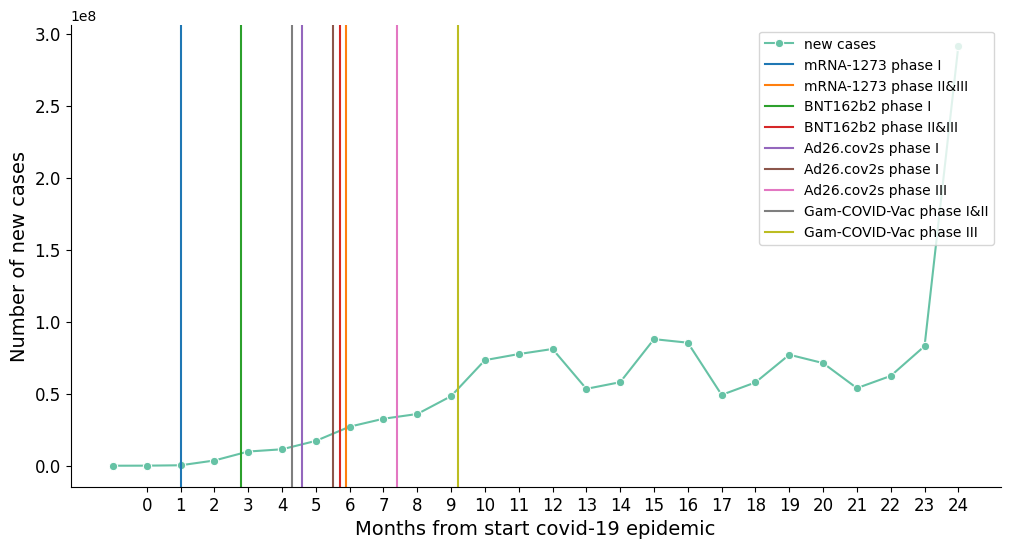

In [11]:
sns.set_palette("Set2")
df = cases_25.groupby("months_from_start")["new_cases"].sum()
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y=df.values, marker="o", label="new cases")
plt.xticks(range(0, 25))

for i, row in trial.iterrows():
    line = plt.gca().axvline(x=row["months_from_start"], color=sns.color_palette("tab10", 9)[i], label=row["vaccine"])
    line.set_xdata([row["months_from_start"]-0.1*i, row["months_from_start"]-0.1*i])

plt.legend(loc="upper right")

plt.xlabel("Months from start covid-19 epidemic", fontsize=14)
plt.ylabel("Number of new cases", fontsize=14)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("myplot.png", dpi=1000)
plt.show()

In [5]:
ml = data.drop(columns=data.select_dtypes(include="object").columns)
ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314835 entries, 0 to 314834
Data columns (total 62 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   total_cases                                 278750 non-null  float64
 1   new_cases                                   306117 non-null  float64
 2   new_cases_smoothed                          304853 non-null  float64
 3   total_deaths                                257954 non-null  float64
 4   new_deaths                                  306200 non-null  float64
 5   new_deaths_smoothed                         304970 non-null  float64
 6   total_cases_per_million                     278750 non-null  float64
 7   new_cases_per_million                       306117 non-null  float64
 8   new_cases_smoothed_per_million              304853 non-null  float64
 9   total_deaths_per_million                    257954 non-null  float64
 

<Axes: xlabel='new_cases_smoothed', ylabel='new_people_vaccinated_smoothed'>

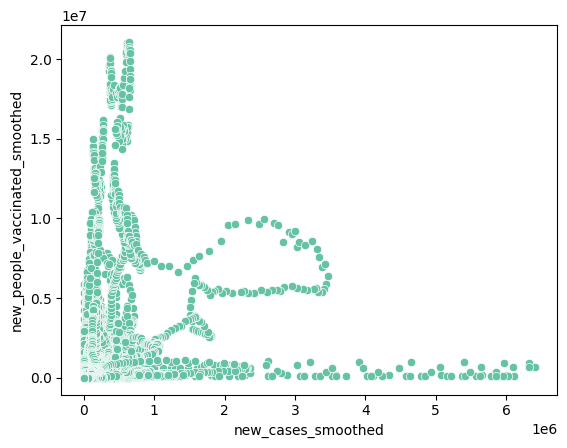

In [6]:
import re

smoothed_cols = ml.filter(regex='smoothed').columns.tolist()
df = ml[smoothed_cols]
df = df[["new_cases_smoothed", "new_people_vaccinated_smoothed"]].dropna()

# df = df[(df["new_cases_smoothed"] != 0) & (df["new_people_vaccinated_smoothed"] != 0)]
# def remove_outliers(df, col):
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
#     return df

# df = remove_outliers(df, "new_cases_smoothed")
# df = remove_outliers(df, "new_people_vaccinated_smoothed")

sns.scatterplot(data=df, x="new_cases_smoothed", y="new_people_vaccinated_smoothed")

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
import numpy as np

df = ml[["total_deaths", "new_vaccinations"]].dropna()
df = df[df["total_deaths"] > 1000000]

# X = df.drop(columns=["new_vaccinations"])
# y = df["new_vaccinations"]

X = df["total_deaths"].values[:, np.newaxis]
y = df["new_vaccinations"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# pipeline = make_pipeline(StandardScaler(), MLPRegressor())
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)
# model = MLPRegressor()
# model.fit(X_train, y_train)
scaler = PolynomialFeatures(degree=3, include_bias=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print("MAE train:", mean_absolute_error(y_pred=y_pred, y_true=y_train))

y_pred = model.predict(X_test)
print("MAE test:", mean_absolute_error(y_pred=y_pred, y_true=y_test))

print(model.coef_)
equation = r"$y = " + str(model.intercept_) + " + " + " + ".join(["(" + str(x) + ")" + "x^" + str(i+1) for i, x in enumerate(model.coef_)]) + "$"

print(equation)


MAE train: 4374387.449227779
MAE test: 4509412.606539126
[-4.08634982e+01  1.55558961e-05 -1.51038217e-12]
$y = 33526432.85845344 + (-40.86349820035998)x^1 + (1.5555896059635274e-05)x^2 + (-1.5103821737598144e-12)x^3$


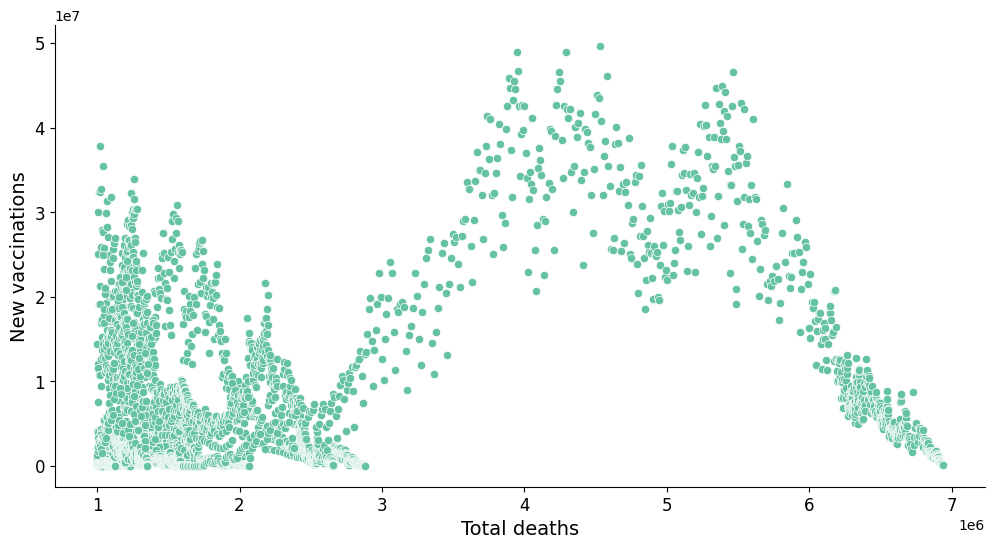

In [10]:
df = ml[["total_deaths", "new_vaccinations"]].dropna()
df = df[df["total_deaths"] > 1000000]

def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
    return df

plt.figure(figsize=(12, 6))
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
sns.scatterplot(x="total_deaths", y="new_vaccinations", data=df)
plt.xlabel("Total deaths", fontsize=14)
plt.ylabel("New vaccinations", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("myplot2.png", dpi=1000)
plt.show()